In [252]:
from collections import defaultdict
from datasets import DatasetDict
from datasets import get_dataset_config_names
from datasets import load_dataset
import pandas as pd
from collections import Counter
import os

import torch.nn as nn
from torch.nn.functional import cross_entropy
import torch
from transformers import XLMRobertaConfig
from transformers import AutoModel
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import DataCollatorForTokenClassification
from transformers import Trainer

from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print(f"Current position: {os.getcwd()}")

Current position: /home/triet/dev/transformers-NLP/mNER


## Preprocessing PANX multilingual dataset

In [3]:
# Load dataset in different languages with their real fractions
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)
for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
        )

Reusing dataset xtreme (/home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 323.64it/s]
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ad1b311e95818edf.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9e4b5e384626785e.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b80ca41f318cd7e7.arrow


de: 20000


Reusing dataset xtreme (/home/triet/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 331.09it/s]
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-222f2a739e50779b.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ae79577dfb0e7498.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-0bc206f54324de18.arrow


fr: 20000


Reusing dataset xtreme (/home/triet/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 461.20it/s]
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-2a286f85a785394c.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-55894a1d8ab171ae.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b2a9c20bbec1f943.arrow


it: 20000


Reusing dataset xtreme (/home/triet/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)
100%|███████████████████████████████████████████████| 3/3 [00:00<00:00, 452.41it/s]
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-b91db9df81081a1f.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-dea8d95ed2e6a82a.arrow
Loading cached shuffled indices for dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-56dba7892a30e39c.arrow


en: 20000


In [4]:
# Number of training examples after selection
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [5]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [6]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [7]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(f"Tags: {tags}")

Tags: ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [8]:
# Create new column in training set with class names for each tag
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [9]:
panx_de = panx_ch["de"].map(create_tag_names)

Loading cached processed dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-f7d2398e6eaab4ad.arrow
Loading cached processed dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-ddea9541044760d1.arrow
Loading cached processed dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-89ded413b451aabb.arrow


In [123]:
# Quick check if there are imbalance in tags
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## Custom Multilingual Transformers

In [11]:
xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [12]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        # Return model output object
        return TokenClassifierOutput(loss=loss, 
                                     logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

In [13]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [14]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'roberta

In [15]:
# Helper function to attach tags for tokens
def tag_text(text, tags, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model(input_ids).logits
    predictions = torch.argmax(outputs, dim=-1)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## Tokenize texts for NER

In [16]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [17]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [18]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Loading cached processed dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-db8d6c8740265b2e.arrow
100%|████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.40ba/s]
Loading cached processed dataset at /home/triet/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-889463a830b4e117.arrow


### Calculate metrics

In [21]:
def align_predictions(predictions, labels_ids):
    preds = np.argmax(predictions, axis=-1)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx, seq_idx]])
                example_preds.append(index2tag[preds[batch_idx, seq_idx]])
            
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    return preds_list, labels_list

### Fine-tune XLM-RoBERTa

In [22]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch", 
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False, 
    logging_steps=logging_steps)

In [23]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [24]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [25]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [26]:
trainer = Trainer(model_init=model_init, args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

### Error Analysis

In [141]:
trained_model = XLMRobertaForTokenClassification.from_pretrained("triet1102/xlm-roberta-base-finetuned-panx-de")
trainer = Trainer(model=trained_model, 
                  args=training_args, 
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"], 
                  tokenizer=xlmr_tokenizer)

In [187]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss": loss, "predicted_label": predicted_label}

In [299]:
x = panx_de_encoded["validation"][:10]
f = [dict(zip(x, t)) for t in zip(*x.values())]
b = data_collator(f)
b

{'input_ids': tensor([[     0,  10699,     11,     15,  16104,   1388,      2,      1,      1,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1],
         [     0,  56530,  25216,  30121, 152385,  19229,  83982,   1002,    170,
              10,    434,    188,  31721,    299,    170,     57,  15263,      2,
               1,      1],
         [     0, 159093,    165,  38506,    122, 153080,  29088,  57432,    339,
             304,    142,      6,      5,      2,      1,      1,      1,      1,
               1,      1],
         [     0,  16459,    242,   5106,      6, 198715,   5106,    242,      2,
               1,      1,      1,      1,      1,      1,      1,      1,      1,
               1,      1],
         [     0,  11022,   2315,   7418,   1079,   8186,  57242,     97,   1663,
              72,  10385,    404,  92962, 118659,  11946,      6,      5,      2,
               1,      1],
         [     0,  42814,   5140

In [188]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

100%|████████████████████████████████████████████| 197/197 [05:04<00:00,  1.54s/ba]


In [189]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.011659336, 0.0, 0.017502148, 0.0132459...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00020537652, 0.0, 0.0, 0.0, 0.0, 1.246...","[6, 0, 0, 0, 0, 0, 5, 1, 2, 2, 2, 2, 2, 2, 2, ..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00021479207, 0.00014053787, 0.00021312...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00018237358, 0.00016127716, 0.00018976...","[0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.00019512657, 0.00016056202, 0.00023314...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [190]:
# hide_output
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.011659336, 0.0, 0.017502148, 0.0132459...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [191]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.25,B-LOC,▁Luz
1,10,1,I-ORG,1.79,I-PER,▁a


In [199]:
type(df_tokens[["loss", "input_ids"]])

pandas.core.frame.DataFrame

In [293]:
(df_tokens.groupby("input_tokens")[['loss']]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="sum", ascending=False)
 .reset_index()
 .round(2)
 .head(10)
 .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁von,▁der,▁und,▁/,▁'',▁(,▁),▁A
count,6066,989,808,1388,1171,163,2898,246,246,125
mean,0.04,0.14,0.16,0.09,0.08,0.48,0.03,0.31,0.3,0.47
sum,228.33,140.17,132.6,122.15,95.71,78.78,76.49,76.08,73.12,58.22


In [248]:
(df_tokens.groupby("labels")[["loss"]]
 .agg(["count", "mean", "sum"])
 .droplevel(level=0, axis=1)
 .sort_values(by="mean", ascending=False)
 .reset_index()
 .round(2)
 .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.64,0.6,0.5,0.34,0.28,0.18,0.03
sum,1711.17,870.84,1908.65,1063.55,812.92,764.32,1289.42


In [291]:
def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

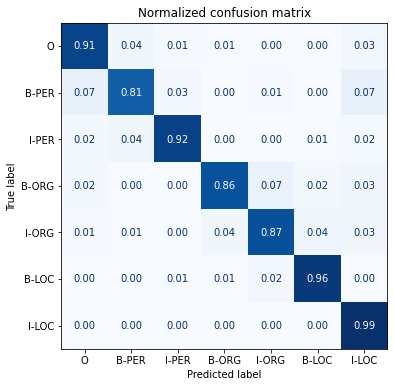

In [292]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)